In [ ]:
!pip install -q diffusers transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.7 MB/s eta 0:00:00


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel, AutoencoderKL
from transformers import CLIPTokenizer, CLIPTextModel
from accelerate import Accelerator
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from datetime import datetime

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


data_dir = "/content/drive/MyDrive/CLIP_training_data"
metadata_path = os.path.join(data_dir, "metadata.csv")

Mounted at /content/drive


In [ ]:
# Load the CSV file
df = pd.read_csv(metadata_path)

# Split the data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.1, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.3, random_state=42)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=77):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['text']
        inputs = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {key: val.squeeze(0) for key, val in inputs.items()}

In [1]:
# Set up the model and tokenizer
model_id = "CompVis/stable-diffusion-v1-4"
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")


NameError: name 'CLIPTokenizer' is not defined

In [ ]:
# Create datasets and dataloaders
train_dataset = TextDataset(train_df, tokenizer)
val_dataset = TextDataset(val_df, tokenizer)
test_dataset = TextDataset(test_df, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Training settings
num_epochs = 10
learning_rate = 1e-5
max_grad_norm = 1.0

In [ ]:
# Initialize optimizer
optimizer = torch.optim.AdamW(text_encoder.parameters(), lr=learning_rate)

# Initialize accelerator
accelerator = Accelerator(mixed_precision="fp16")

# Prepare models for training
text_encoder, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    text_encoder, optimizer, train_dataloader, val_dataloader
)

In [ ]:
def get_timestamp():
    return datetime.now().strftime("%Y%m%d_%H%M%S")

In [ ]:
checkpoint_dir = "/content/drive/MyDrive/checkpoints"
best_model_dir = "/content/drive/MyDrive/best_model"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(best_model_dir, exist_ok=True)

In [ ]:
# Training loop
best_val_loss = float('inf')
start_time = get_timestamp()

for epoch in range(num_epochs):
    text_encoder.train()
    train_loss = 0.0
    train_progress_bar = tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1} (Train)")

    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(text_encoder):
            outputs = text_encoder(**batch)
            loss = outputs.pooler_output.mean()
            accelerator.backward(loss)
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(text_encoder.parameters(), max_grad_norm)
            optimizer.step()
            optimizer.zero_grad()

        train_loss += loss.detach().item()
        train_progress_bar.update(1)
        train_progress_bar.set_postfix({"loss": loss.detach().item()})

    train_loss /= len(train_dataloader)
    train_progress_bar.close()

    # Validation loop
    text_encoder.eval()
    val_loss = 0.0
    val_progress_bar = tqdm(total=len(val_dataloader), desc=f"Epoch {epoch+1} (Val)")

    with torch.no_grad():
        for batch in val_dataloader:
            outputs = text_encoder(**batch)
            loss = outputs.pooler_output.mean()
            val_loss += loss.item()
            val_progress_bar.update(1)
            val_progress_bar.set_postfix({"loss": loss.item()})

    val_loss /= len(val_dataloader)
    val_progress_bar.close()

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save checkpoint with timestamp
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}_{get_timestamp()}.pth")
    accelerator.save_state(checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

    # Save best model with timestamp
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        if accelerator.is_main_process:
            text_encoder = accelerator.unwrap_model(text_encoder)
            best_model_path = os.path.join(best_model_dir, f"best_model_{get_timestamp()}")
            text_encoder.save_pretrained(best_model_path)
            print(f"New best model saved with validation loss: {best_val_loss:.4f}")
            print(f"Best model path: {best_model_path}")

print("Training completed.")

Epoch 1 (Train):   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 (Val):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Train Loss: -0.1903, Val Loss: -0.2067
Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch_1_20240811_234910.pth
New best model saved with validation loss: -0.2067
Best model path: /content/drive/MyDrive/best_model/best_model_20240811_234918


Epoch 2 (Train):   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2 (Val):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: Train Loss: -0.2073, Val Loss: -0.2077
Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch_2_20240811_234935.pth
New best model saved with validation loss: -0.2077
Best model path: /content/drive/MyDrive/best_model/best_model_20240811_234944


Epoch 3 (Train):   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3 (Val):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: Train Loss: -0.2081, Val Loss: -0.2085
Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch_3_20240811_234954.pth
New best model saved with validation loss: -0.2085
Best model path: /content/drive/MyDrive/best_model/best_model_20240811_235007


Epoch 4 (Train):   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4 (Val):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: Train Loss: -0.2088, Val Loss: -0.2092
Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch_4_20240811_235029.pth
New best model saved with validation loss: -0.2092
Best model path: /content/drive/MyDrive/best_model/best_model_20240811_235047


Epoch 5 (Train):   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5 (Val):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: Train Loss: -0.2096, Val Loss: -0.2099
Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch_5_20240811_235056.pth
New best model saved with validation loss: -0.2099
Best model path: /content/drive/MyDrive/best_model/best_model_20240811_235222


Epoch 6 (Train):   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6 (Val):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: Train Loss: -0.2103, Val Loss: -0.2107
Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch_6_20240811_235232.pth
New best model saved with validation loss: -0.2107
Best model path: /content/drive/MyDrive/best_model/best_model_20240811_235255


Epoch 7 (Train):   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7 (Val):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: Train Loss: -0.2110, Val Loss: -0.2114
Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch_7_20240811_235313.pth
New best model saved with validation loss: -0.2114
Best model path: /content/drive/MyDrive/best_model/best_model_20240811_235333


Epoch 8 (Train):   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8 (Val):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: Train Loss: -0.2118, Val Loss: -0.2121
Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch_8_20240811_235349.pth
New best model saved with validation loss: -0.2121
Best model path: /content/drive/MyDrive/best_model/best_model_20240811_235417


Epoch 9 (Train):   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9 (Val):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: Train Loss: -0.2125, Val Loss: -0.2129
Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch_9_20240811_235426.pth
New best model saved with validation loss: -0.2129
Best model path: /content/drive/MyDrive/best_model/best_model_20240811_235433


Epoch 10 (Train):   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10 (Val):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: Train Loss: -0.2132, Val Loss: -0.2136
Checkpoint saved: /content/drive/MyDrive/checkpoints/checkpoint_epoch_10_20240811_235446.pth
New best model saved with validation loss: -0.2136
Best model path: /content/drive/MyDrive/best_model/best_model_20240811_235453
Training completed.


In [ ]:
# Find the latest best model
best_model_files = [f for f in os.listdir(best_model_dir) if f.startswith("best_model_")]
latest_best_model = max(best_model_files, key=lambda x: os.path.getctime(os.path.join(best_model_dir, x)))
latest_best_model_path = os.path.join(best_model_dir, latest_best_model)

print(f"Latest best model found: {latest_best_model_path}")

Latest best model found: /content/drive/MyDrive/best_model/best_model_20240811_235453


In [ ]:
# Load the best model for inference
best_text_encoder = CLIPTextModel.from_pretrained(latest_best_model_path, torch_dtype=torch.float16).to(device)

In [ ]:
# Load the original Stable Diffusion pipeline and replace the text encoder
pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)
pipeline.text_encoder = best_text_encoder

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Test the model
test_loss = 0.0
test_progress_bar = tqdm(total=len(test_dataloader), desc="Testing")

with torch.no_grad():
    for batch in test_dataloader:
        outputs = best_text_encoder(**batch)
        loss = outputs.pooler_output.mean()
        test_loss += loss.item()
        test_progress_bar.update(1)
        test_progress_bar.set_postfix({"loss": loss.item()})

test_loss /= len(test_dataloader)
test_progress_bar.close()

print(f"Test Loss: {test_loss:.4f}")

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

  0%|          | 0/50 [00:00<?, ?it/s]

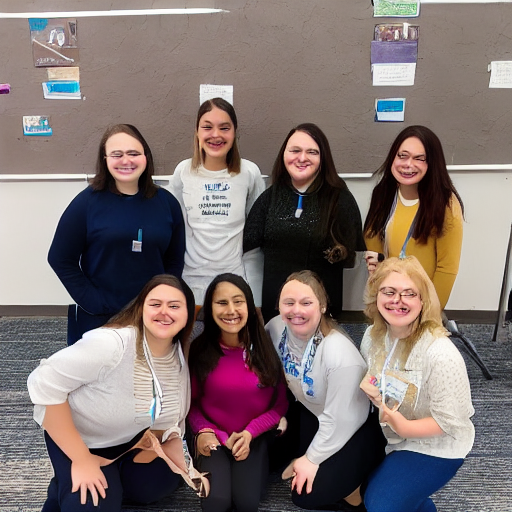

Generated image for prompt: a close up photo of herpes simplex skin condition on arms on white skin


  0%|          | 0/50 [00:00<?, ?it/s]

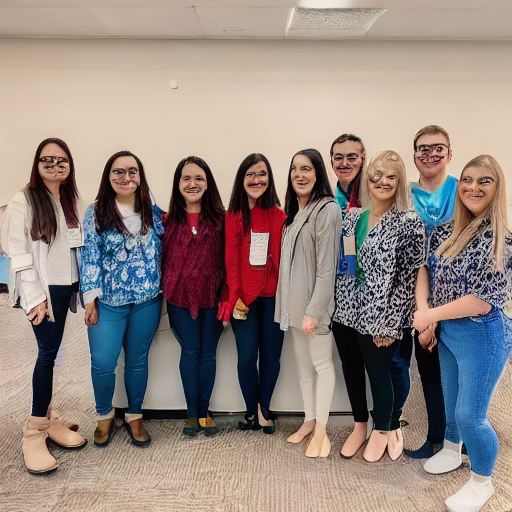

Generated image for prompt: a at distance photo of herpes simplex skin condition on neck on brown skin


  0%|          | 0/50 [00:00<?, ?it/s]

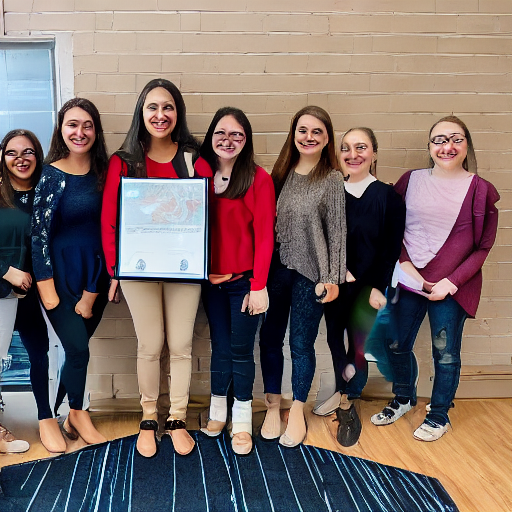

Generated image for prompt: a at an angle photo of herpes simplex skin condition on legs on fair skin
Image generation completed.


In [ ]:
# Generate images
from IPython.display import display

prompts = [
    "a close up photo of herpes simplex skin condition on arms on white skin",
    "a at distance photo of herpes simplex skin condition on neck on brown skin",
    "a at an angle photo of herpes simplex skin condition on legs on fair skin"
]

for i, prompt in enumerate(prompts):
    image = pipeline(prompt).images[0]
    # image_filename = f"generated_image_{i}_{get_timestamp()}.png"
    # image_path = os.path.join("/content/drive/MyDrive", image_filename)
    # image.save(image_path)
    display(image)
    print(f"Generated image for prompt: {prompt}")
    # print(f"Image saved: {image_path}")

print("Image generation completed.")